<a href="https://colab.research.google.com/github/maya-papaya/Analyzing-Protests-Through-Tweets/blob/main/Step%203%3A%20Conducting%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Conducting Analysis

Now, we will perform the final step of this project: conducting our analysis!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers datasets
! pip install keybert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23767 sha256=4326bd369ff41ffafab5c96171046

First, we have to upload our datasets from Google Drive and convert them to Dataset objects.

In [ ]:
import pandas as pd
from datasets import Dataset

womenmarch = pd.read_csv('/content/drive/MyDrive/womenmarch.csv')
womenmarch = Dataset.from_pandas(pd.DataFrame(data=womenmarch))

farmers = pd.read_csv('/content/drive/MyDrive/farmers.csv')
farmers = Dataset.from_pandas(pd.DataFrame(data=farmers))

In [ ]:
from datetime import datetime

farmers = farmers.add_column("datetime", [datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00') for x in farmers['date']])

We're also going to load our models.

In [ ]:
from transformers import AutoModelForSequenceClassification
from keybert import KeyBERT

sentiment_model = AutoModelForSequenceClassification.from_pretrained('mayapapaya/Sentiment-Analyzer')
keyword_model = KeyBERT()

Now, we can start conducting our analysis!


---

# Analysis

In this analysis, I am creating three different functions, each with their own task: public sentiment, public sentiment within a certain time period, and keyword extracting.


### Function 1: Public Sentiment
This function is to determine the majority sentiment towards the movement.

*Parameters: dataset, tweet_index*

*Return Value: variables that list the sentiments of a dataset of tweets*

In [ ]:
from transformers import pipeline

def public_sentiment(dataset, tweet_index):
  positive, negative, neutral = [], [], []

  # Input the tweet text into the model
  generator = pipeline('sentiment-analysis',
                    model=sentiment_model,
                    tokenizer='bert-base-uncased')

  # Determine the tweet text's sentiment
  for row in dataset:
    sentiment = generator(row[tweet_index], max_length=512, truncation=True)
    if sentiment[0]['label'] == "LABEL_1":
      neutral.append(row[tweet_index])
    elif sentiment[0]['label'] == "LABEL_0":
      negative.append(row[tweet_index])
    elif sentiment[0]['label'] == "LABEL_2":
      positive.append(row[tweet_index])

  # Returns a list of each sentiment and the total number of tweets
  return len(dataset), positive, neutral, negative

### Function 2: Segmenting Dataset by Date

This function segments a dataset within the specified time period.

*Parameters: start_date, end_date (both are datetime objects), dataset, time_index*

*Return Value: a dataset*

In [ ]:
def segment_by_date(start_date, end_date, dataset, time_index):

  start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S+00:00')
  end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S+00:00')

  # Segment dataset into the specified time period
  start_date_index = 0
  end_date_index = len(dataset) - 1

  for i in range(end_date_index + 1):
    if start_date_index != 0 or dataset[i][time_index] >= start_date:
      start_date_index = i
      break

  for i in range(start_date_index, len(dataset)):
      if end_date <= dataset[i][time_index]:
        end_date_index = i
        break

  seg_dataset = Dataset.from_dict(dataset[start_date_index:end_date_index])

  return seg_dataset

### Function 3: Keyword Extractor

This function is to determine the most popular keywords or topics of discussion.

*Parameters: dataset*

*Return Value: dictionary where keys are keywords and values are the percentages they appeared*

In [ ]:
def keyword_extractor(dataset):
  keyword_to_percent = {}

  for tweet in dataset:
    # Input the tweet text into the model
    tweet_keywords = keyword_model.extract_keywords(tweet, keyphrase_ngram_range=(1, 2))

    for keyword in tweet_keywords:
      if keyword[0] not in keyword_to_percent:
        keyword_to_percent[keyword[0]] = 1
      else:
        keyword_to_percent[keyword[0]] += 1


  return sorted(keyword_to_percent.items(), key=lambda x:x[1], reverse=True)

### Function 4: Hashtag Analyzer

This function is to create a dictionary of all the hashtags used in a dataset as well as the number of times they appear.

*Parameters: dataset*

*Return Value: dictionary where keys are hashtags and values are the number of times they appeared*

In [ ]:
def hashtag(dataset):
  hashtags = {}
  for tags in dataset['hashtag']:
    if tags == None:
      break
    tags = tags.split()
    for tag in tags:
      if tag not in hashtags:
        hashtags[tag] = 1
      else:
        hashtags[tag] += 1

  return hashtags

### Function 5: Wordcloud Generator

This function prints wordclouds based on the tweet texts provided in a dataset. (I borrowed the code from this analysis: https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061)

*Parameters: data*

*Return Value: None*

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
  wordcloud = WordCloud(
      background_color = 'white',
      max_words = 200,
      max_font_size = 40,
      scale = 3,
      random_state = 42
      ).generate(str(data))
  fig = plt.figure(1, figsize = (15, 15))
  plt.axis('off')
  if title:
      fig.suptitle(title, fontsize = 20)
      fig.subplots_adjust(top = 2.3)
  plt.imshow(wordcloud)
  plt.show()

### Extra Functions

In [ ]:
def print_top(my_list, num):
  counter = 1
  for keyword in my_list:
    print(str(counter) + ". " + str(keyword))
    if counter == num:
      break
    counter += 1

This function is meant to simplify and condense the analysis for each dataset into a single function call.

In [ ]:
def analyze(dataset, start_date, end_date, tweet_index):
  print("Public Sentiment between " + start_date + " and " + end_date + ": ")
  print()

  # Prints the sentiments
  length, positives, neutrals, negatives = public_sentiment(dataset, tweet_index)
  print("Positive Tweets: " + str(len(positives)))
  print("Neutral Tweets: " + str(len(neutrals)))
  print("Negative Tweets: " + str(len(negatives)))
  print()
  print("Total Tweets: " + str(length))
  print()

  # Prints the top ten keywords
  print("Keywords:")
  keyword_to_percent = keyword_extractor(dataset[tweet_index])
  print_top(keyword_to_percent, 10)
  print()
  print("Positive Keywords: ")
  keyword_to_percent = keyword_extractor(positives)
  print_top(keyword_to_percent, 10)
  print()
  print("Neutral Keywords: ")
  keyword_to_percent = keyword_extractor(neutrals)
  print_top(keyword_to_percent, 10)
  print()
  print("Negative Keywords: ")
  keyword_to_percent = keyword_extractor(negatives)
  print_top(keyword_to_percent, 10)
  print()

  # Prints the wordclouds for each sentiment
  print("Wordcloud (Positive):")
  show_wordcloud(positives)
  print("Wordcloud (Negative):")
  show_wordcloud(negatives)
  print("Wordcloud (Neutral):")
  show_wordcloud(neutrals)

  # Prints the hashtags for each dataset
  print("Hashtags:")
  hashtags = hashtag(dataset)
  print_top(hashtags, 10)

  return length, positives, neutrals, negatives, keyword_to_percent


Now let's analyze our datasets using these functions!

## WomensMarch Analysis

We'll start with the #WomensMarch dataset:

Public Sentiment between 2017-02-08 05:14:24 and 2017-02-07 04:09:25: 

Positive Tweets: 3747
Neutral Tweets: 7766
Negative Tweets: 3487

Total Tweets: 15000

Keywords:
1. ('womensmarch', 7314)
2. ('future female', 1777)
3. ('clinton says', 1675)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('devos', 1501)
7. ('education devos', 1489)
8. ('communities womensmarch', 1488)
9. ('womensmarch power', 1486)
10. ('demi lovato', 944)

Positive Keywords: 
1. ('womensmarch', 2032)
2. ('unstoppable womensmarch', 641)
3. ('cecilerichards movement', 640)
4. ('movement unstoppable', 640)
5. ('womensmarch agree', 638)
6. ('shoutout womensmarch', 384)
7. ('hillaryclinton shoutout', 382)
8. ('thank hillaryclinton', 381)
9. ('womensmarch thank', 380)
10. ('patriotsparade liberal', 342)

Neutral Keywords: 
1. ('womensmarch', 4553)
2. ('future female', 1752)
3. ('clinton says', 1675)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('devos', 1488)
7. ('womensm

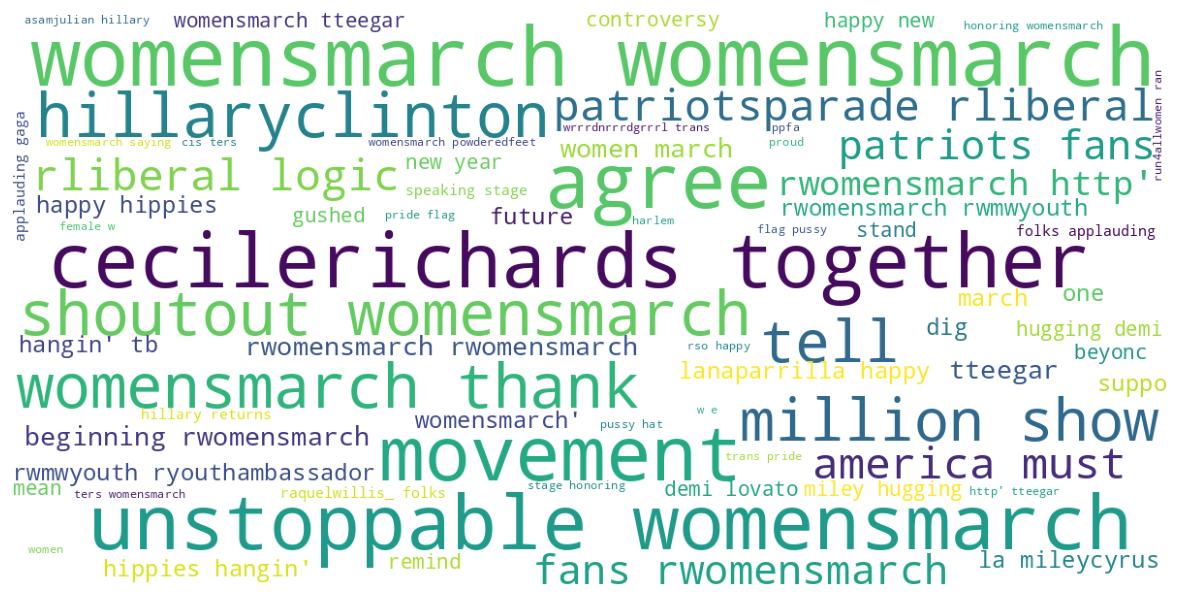

Wordcloud (Negative):


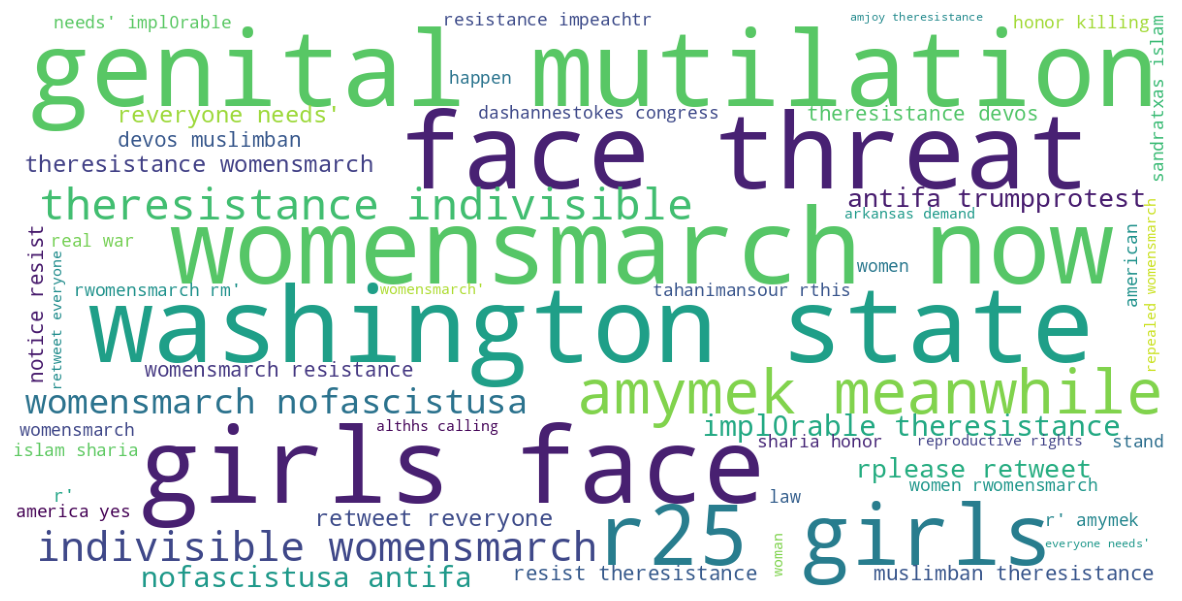

Wordcloud (Neutral):


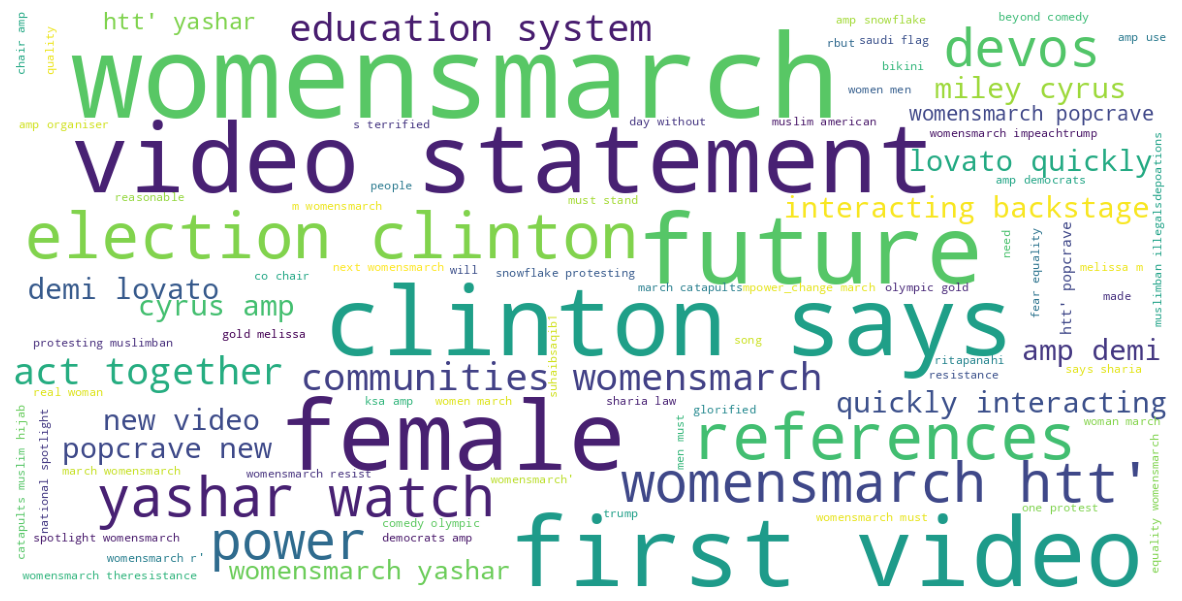

Hashtags:
1. letlizspeak
2. sallyyates
3. womensmarch
4. melissamccarthy
5. bansharia
6. hush
7. devos
8. theresistance
9. indivisible
10. nofascistusa


In [ ]:
length, positives, neutrals, negatives, keyword_to_percent = analyze(womenmarch, womenmarch['created'][0], womenmarch['created'][-1], 'text')


```
Public Sentiment between 2017-02-08 05:14:24 and 2017-02-07 04:09:25:

Positive Tweets: 3747
Neutral Tweets: 7766
Negative Tweets: 3487

Total Tweets: 15000

Keywords:
1. ('womensmarch', 7314)
2. ('future female', 1777)
3. ('clinton says', 1675)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('devos', 1501)
7. ('education devos', 1489)
8. ('communities womensmarch', 1488)
9. ('womensmarch power', 1486)
10. ('demi lovato', 944)

Positive Keywords:
1. ('womensmarch', 2032)
2. ('unstoppable womensmarch', 641)
3. ('cecilerichards movement', 640)
4. ('movement unstoppable', 640)
5. ('womensmarch agree', 638)
6. ('shoutout womensmarch', 384)
7. ('hillaryclinton shoutout', 382)
8. ('thank hillaryclinton', 381)
9. ('womensmarch thank', 380)
10. ('patriotsparade liberal', 342)

Neutral Keywords:
1. ('womensmarch', 4553)
2. ('future female', 1752)
3. ('clinton says', 1675)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('devos', 1488)
7. ('womensmarch power', 1486)
8. ('education devos', 1485)
9. ('communities womensmarch', 1485)
10. ('demi', 849)

Negative Keywords:
1. ('womensmarch', 729)
2. ('mutilation', 451)
3. ('genital mutilation', 450)
4. ('threat genital', 442)
5. ('state womensmarch', 442)
6. ('amymek washington', 441)
7. ('womensmarch nofascistusa', 407)
8. ('trumpprotest', 407)
9. ('antifa trumpprotest', 406)
10. ('impl0rable', 406)

Hashtags:
1. letlizspeak
2. sallyyates
3. womensmarch
4. melissamccarthy
5. bansharia
6. hush
7. devos
8. theresistance
9. indivisible
10. nofascistusa
```



## The Indian Farmers' Protest Analysis

Now, we'll look at our second dataset:

In [ ]:
length, positives, neutrals, negatives, keyword_to_percent = analyze(farmers, "start_date", "end_date", 'renderedContent')



```
Public Sentiment between start_date and end_date:

Positive Tweets: 193,742
Neutral Tweets: 504,129
Negative Tweets: 386,581

Total Tweets: 1,084,452

Keywords:
1. ('farmersprotest', 469192)
2. ('farmers', 84296)
3. ('farmers farmersprotest', 32333)
4. ('support farmers', 29321)
5. ('farmers protest', 20979)
6. ('protest', 20465)
7. ('bjp', 19193)
8. ('support farmersprotest', 17318)
9. ('farm laws', 15796)
10. ('indian farmers', 12893)
```



Public Sentiment between 2020-11-29 00:00:00+00:00 and 2021-03-22 00:00:00+00:00: 



Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Positive Tweets: 120411
Neutral Tweets: 275868
Negative Tweets: 219677

Total Tweets: 615956

Keywords:
1. ('farmersprotest', 208641)
2. ('farmers', 46784)
3. ('farmersprotest twitter', 39073)
4. ('rihanna', 14242)
5. ('farmers farmersprotest', 12662)
6. ('protest', 12199)
7. ('farmers protest', 10557)
8. ('bjp', 10500)
9. ('suppo farmers', 10389)
10. ('suppo farmersprotest', 8273)

Positive Keywords: 
1. ('farmersprotest', 53768)
2. ('farmersprotest twitter', 14727)
3. ('farmers', 8048)
4. ('rihanna', 6687)
5. ('suppo farmersprotest', 3518)
6. ('farmers farmersprotest', 3252)
7. ('gretathunberg', 3174)
8. ('suppo farmers', 2402)
9. ('suppoing farmersprotest', 2010)
10. ('thank farmersprotest', 1910)

Neutral Keywords: 
1. ('farmersprotest', 105683)
2. ('farmers', 21249)
3. ('farmersprotest twitter', 16917)
4. ('farmers farmersprotest', 6986)
5. ('suppo farmers', 6319)
6. ('farmers protest', 5495)
7. ('rihanna', 5147)
8. ('protest', 4833)
9. ('indian farmers', 3825)
10. ('suppo farmers

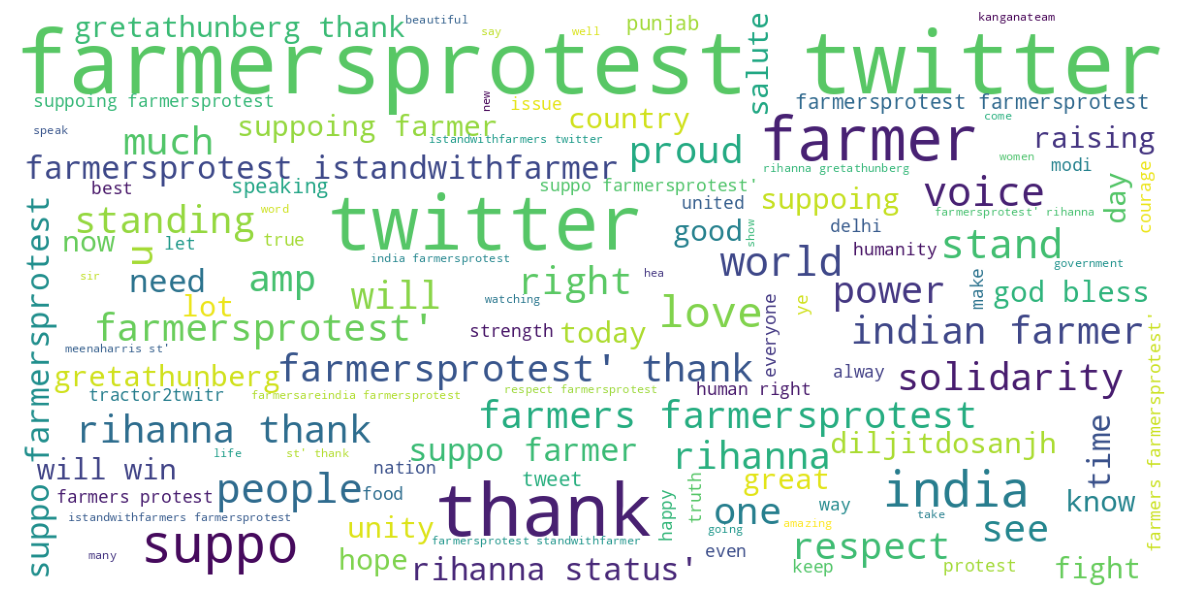

Wordcloud (Negative):


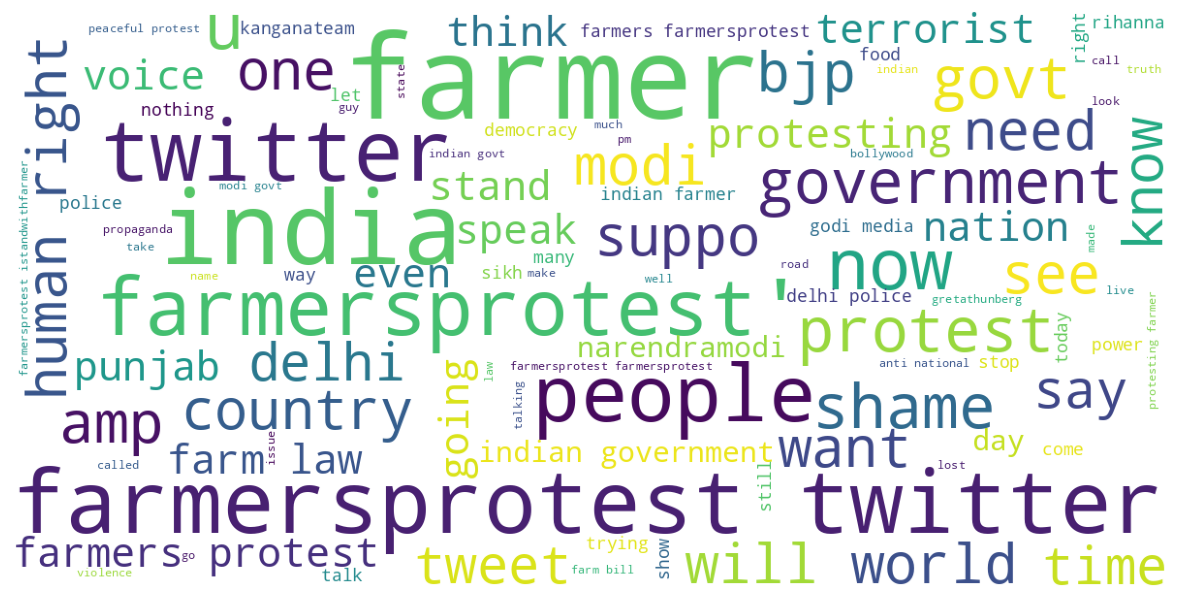

Wordcloud (Neutral):


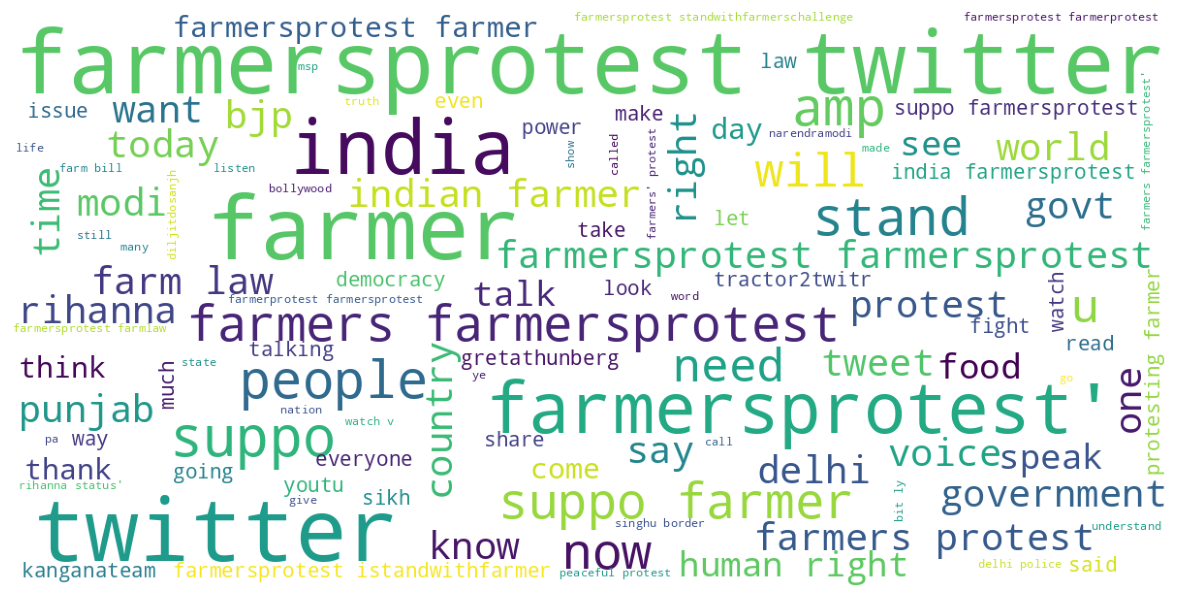

Hashtags:
1. farmersprotest
2. farmersdillichalo
3. kisanandolan
4. isupportfarmars
5. standwithfarmerschallenge
6. istandwithfarmers
7. pm
8. farmersprotests
9. indianarmy
10. farmers


In [ ]:
start_date = "2020-11-29 00:00:00+00:00"
end_date = "2021-03-22 00:00:00+00:00"
seg_dataset1 = segment_by_date(start_date, end_date, farmers, 'datetime')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset1, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2020-11-29 00:00:00+00:00 and 2021-03-22 00:00:00+00:00:

Positive Tweets: 120411
Neutral Tweets: 275868
Negative Tweets: 219677

Total Tweets: 615956

Keywords:
1. ('farmersprotest', 208641)
2. ('farmers', 46784)
3. ('farmersprotest twitter', 39073)
4. ('rihanna', 14242)
5. ('farmers farmersprotest', 12662)
6. ('protest', 12199)
7. ('farmers protest', 10557)
8. ('bjp', 10500)
9. ('suppo farmers', 10389)
10. ('suppo farmersprotest', 8273)

Positive Keywords:
1. ('farmersprotest', 53768)
2. ('farmersprotest twitter', 14727)
3. ('farmers', 8048)
4. ('rihanna', 6687)
5. ('suppo farmersprotest', 3518)
6. ('farmers farmersprotest', 3252)
7. ('gretathunberg', 3174)
8. ('suppo farmers', 2402)
9. ('suppoing farmersprotest', 2010)
10. ('thank farmersprotest', 1910)

Neutral Keywords:
1. ('farmersprotest', 105683)
2. ('farmers', 21249)
3. ('farmersprotest twitter', 16917)
4. ('farmers farmersprotest', 6986)
5. ('suppo farmers', 6319)
6. ('farmers protest', 5495)
7. ('rihanna', 5147)
8. ('protest', 4833)
9. ('indian farmers', 3825)
10. ('suppo farmersprotest', 3824)

```



Public Sentiment between 2021-11-05 00:00:00+00:00 and 2021-11-21 00:00:00+00:00: 

Positive Tweets: 5667
Neutral Tweets: 10145
Negative Tweets: 8756

Total Tweets: 24568

Keywords:
1. ('farmersprotest', 7274)
2. ('farmers', 2223)
3. ('farm laws', 1653)
4. ('farmlaws', 1597)
5. ('farmlawsrepealed', 1455)
6. ('farmersprotest twitter', 879)
7. ('farmlawsrepealed farmersprotest', 870)
8. ('farmlaws farmersprotest', 868)
9. ('farmersprotest farmlaws', 714)
10. ('farmersprotest farmlawsrepealed', 704)

Positive Keywords: 
1. ('farmersprotest', 2303)
2. ('farmers', 577)
3. ('farmersprotest twitter', 360)
4. ('farmlawsrepealed', 323)
5. ('farmlaws', 297)
6. ('farmlawsrepealed farmersprotest', 222)
7. ('farm laws', 195)
8. ('farmlaws farmersprotest', 189)
9. ('farmersprotest farmlawsrepealed', 159)
10. ('farmers farmersprotest', 157)

Neutral Keywords: 
1. ('farmersprotest', 3224)
2. ('farm laws', 855)
3. ('farmlaws', 852)
4. ('farmers', 709)
5. ('farmlawsrepealed', 692)
6. ('farmlaws farmersp

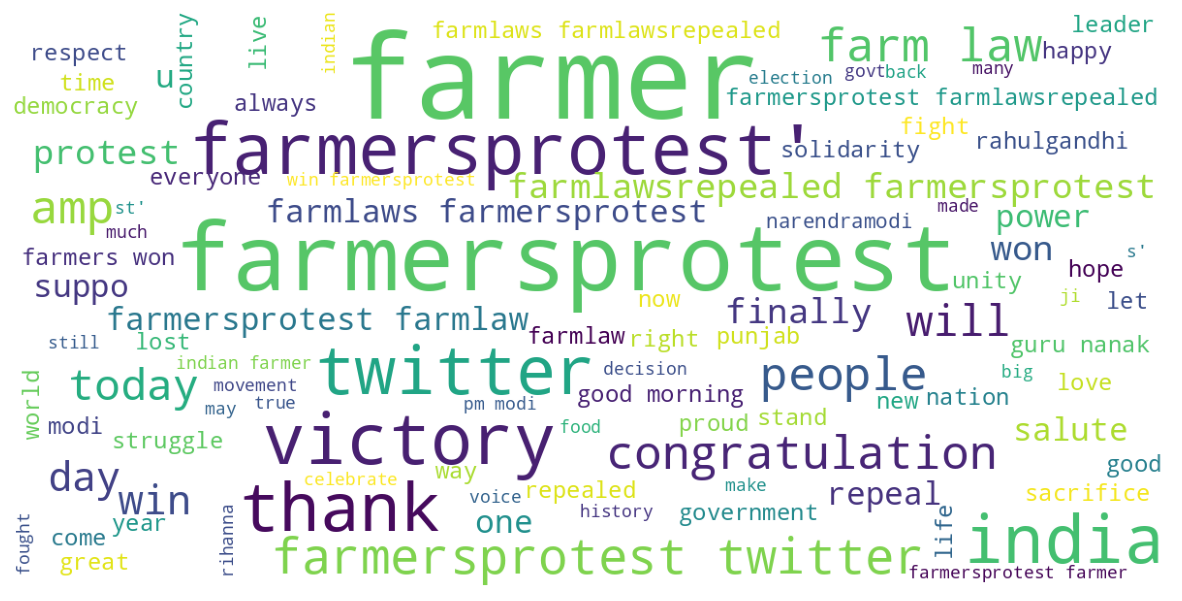

Wordcloud (Negative):


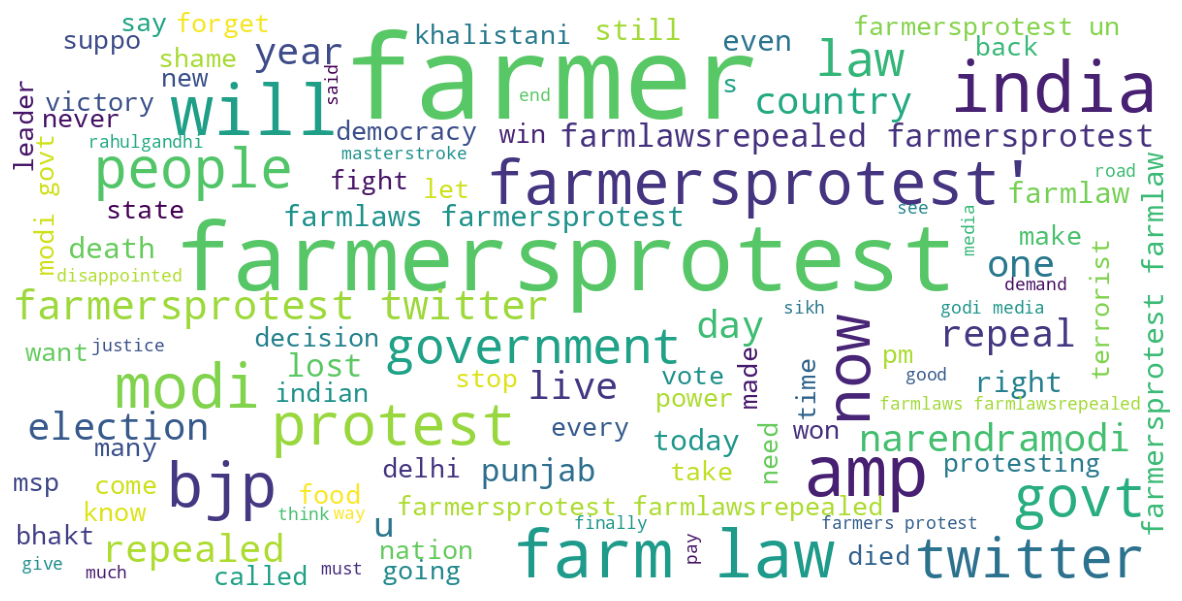

Wordcloud (Neutral):


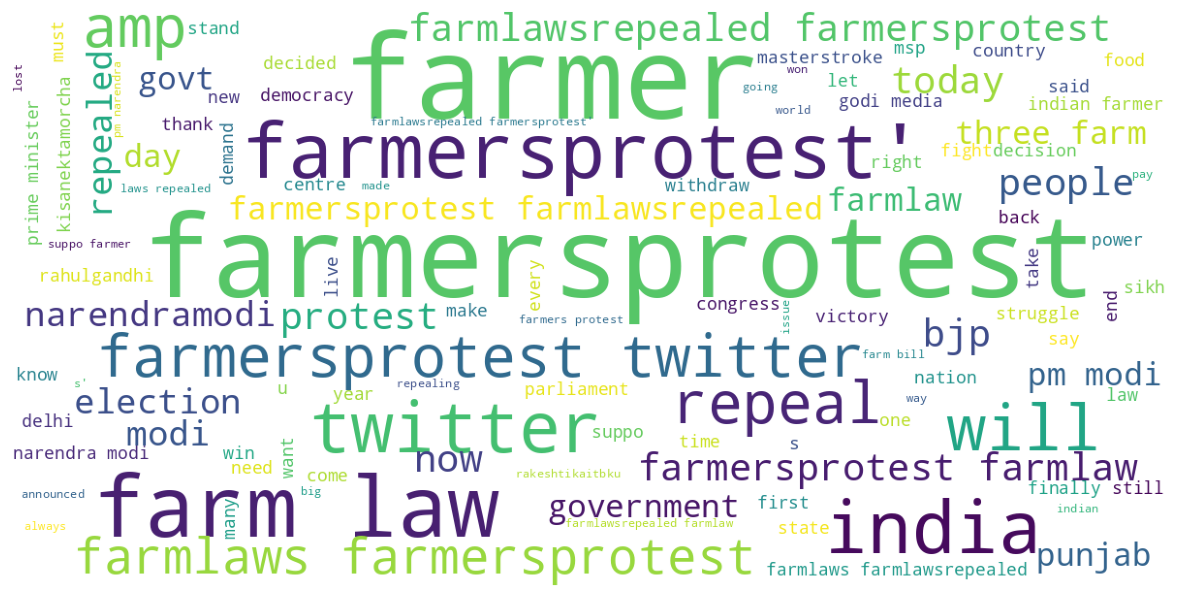

Hashtags:
1. ['3rdgradeactor',
2. 'farmersprotest',
3. 'boycottmodi']
4. ['farmersprotest']
5. ['farmersprotest',
6. 'humanrights']
7. ['happydiwali2021',
8. 'farmers',
9. 'diwaliwithfarmers',
10. 'bandichhordivas']


In [ ]:
start_date = "2021-11-05 00:00:00+00:00"
end_date = "2021-11-21 00:00:00+00:00"
seg_dataset2 = segment_by_date(start_date, end_date, farmers, 'datetime')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset2, start_date, end_date, 'renderedContent')


```
Public Sentiment between 2021-11-05 00:00:00+00:00 and 2021-11-21 00:00:00+00:00:

Positive Tweets: 5667
Neutral Tweets: 10145
Negative Tweets: 8756

Total Tweets: 24568

Keywords:
1. ('farmersprotest', 7274)
2. ('farmers', 2223)
3. ('farm laws', 1653)
4. ('farmlaws', 1597)
5. ('farmlawsrepealed', 1455)
6. ('farmersprotest twitter', 879)
7. ('farmlawsrepealed farmersprotest', 870)
8. ('farmlaws farmersprotest', 868)
9. ('farmersprotest farmlaws', 714)
10. ('farmersprotest farmlawsrepealed', 704)

Positive Keywords:
1. ('farmersprotest', 2303)
2. ('farmers', 577)
3. ('farmersprotest twitter', 360)
4. ('farmlawsrepealed', 323)
5. ('farmlaws', 297)
6. ('farmlawsrepealed farmersprotest', 222)
7. ('farm laws', 195)
8. ('farmlaws farmersprotest', 189)
9. ('farmersprotest farmlawsrepealed', 159)
10. ('farmers farmersprotest', 157)

Neutral Keywords:
1. ('farmersprotest', 3224)
2. ('farm laws', 855)
3. ('farmlaws', 852)
4. ('farmers', 709)
5. ('farmlawsrepealed', 692)
6. ('farmlaws farmersprotest', 451)
7. ('farmlawsrepealed farmersprotest', 390)
8. ('farmersprotest farmlaws', 369)
9. ('farmersprotest twitter', 356)
10. ('farmersprotest farmlawsrepealed', 298)

Negative Keywords:
1. ('farmersprotest', 1747)
2. ('farmers', 937)
3. ('farm laws', 603)
4. ('farmlaws', 448)
5. ('farmlawsrepealed', 440)
6. ('bjp', 394)
7. ('farmlawsrepealed farmersprotest', 258)
8. ('farmersprotest farmlawsrepealed', 247)
9. ('farmlaws farmersprotest', 228)
10. ('farmersprotest farmlaws', 192)

Hashtags:
1. ['3rdgradeactor',
2. 'farmersprotest',
3. 'boycottmodi']
4. ['farmersprotest']
5. ['farmersprotest',
6. 'humanrights']
7. ['happydiwali2021',
8. 'farmers',
9. 'diwaliwithfarmers',
10. 'bandichhordivas']
```


Public Sentiment between 2021-01-26 00:00:00+00:00 and 2021-02-01 00:00:00+00:00: 

Positive Tweets: 3868
Neutral Tweets: 15813
Negative Tweets: 19057

Total Tweets: 38738

Keywords:
1. ('farmersprotest', 11053)
2. ('farmers', 2080)
3. ('farmersprotest twitter', 1601)
4. ('protest', 1206)
5. ('farmers protest', 889)
6. ('delhi police', 798)
7. ('delhi', 738)
8. ('bjp', 674)
9. ('flag', 563)
10. ('sikhs', 549)

Positive Keywords: 
1. ('farmersprotest', 1396)
2. ('farmersprotest twitter', 399)
3. ('republic day', 196)
4. ('farmers', 172)
5. ('historictractormarch farmersprotest', 97)
6. ('republic', 89)
7. ('peacefulprotestcontinues farmersprotest', 79)
8. ('farmersstandingfirm', 75)
9. ('indian republica', 67)
10. ('reclaim indian', 67)

Neutral Keywords: 
1. ('farmersprotest', 5498)
2. ('farmersprotest twitter', 747)
3. ('farmers', 716)
4. ('farmers protest', 476)
5. ('protest', 395)
6. ('tractor rally', 348)
7. ('delhi', 293)
8. ('farmersprotest farmerprotestgazipurborder', 275)
9. ('

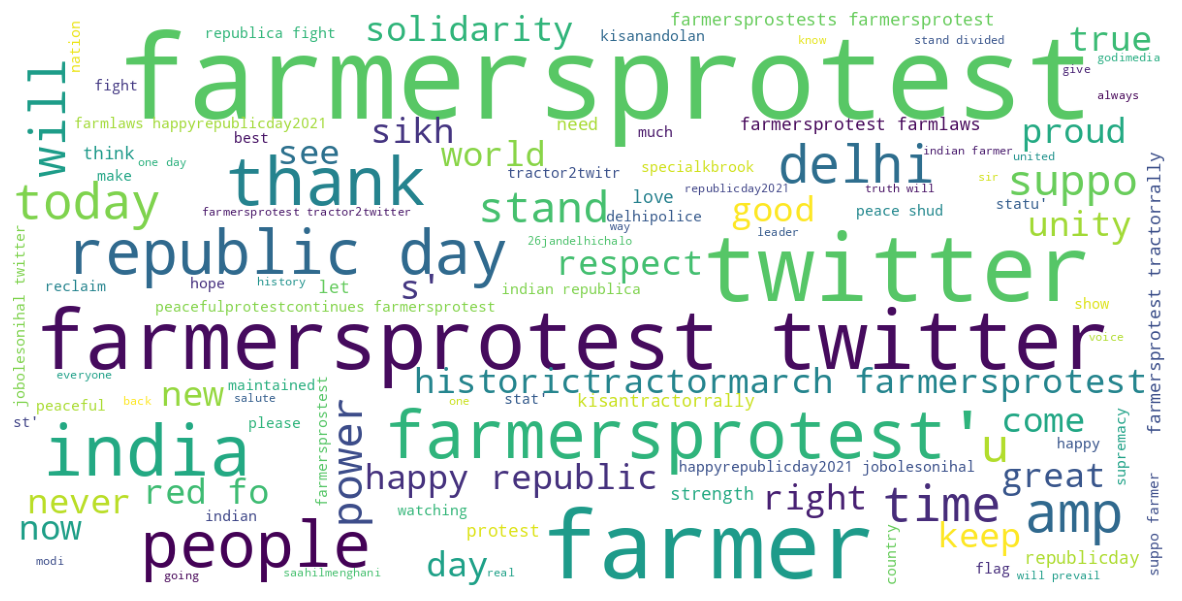

Wordcloud (Negative):


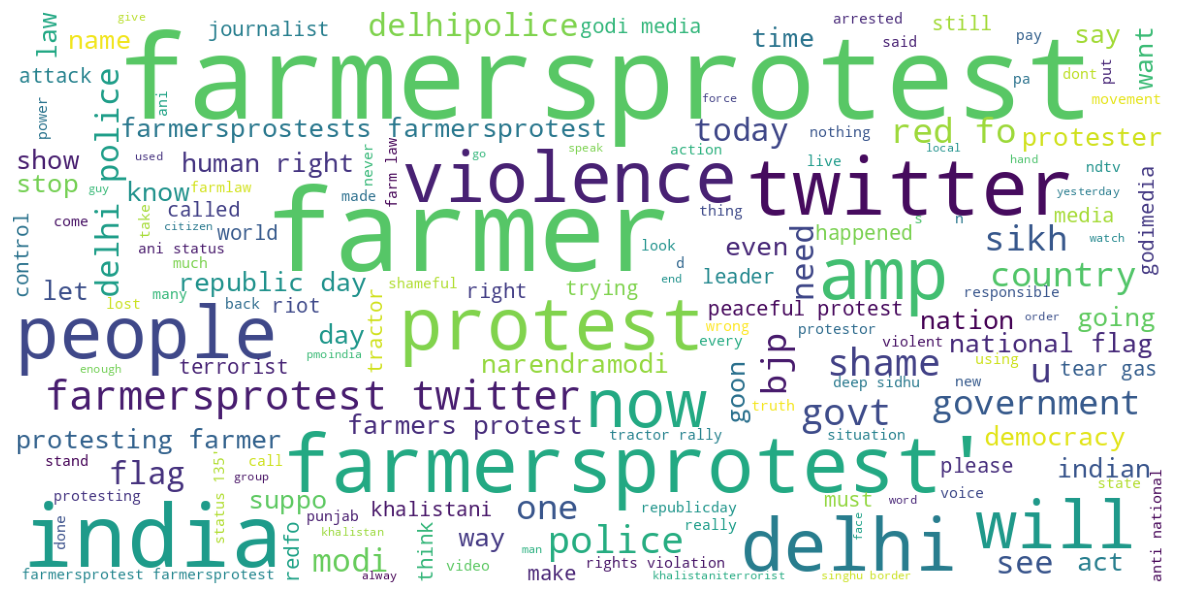

Wordcloud (Neutral):


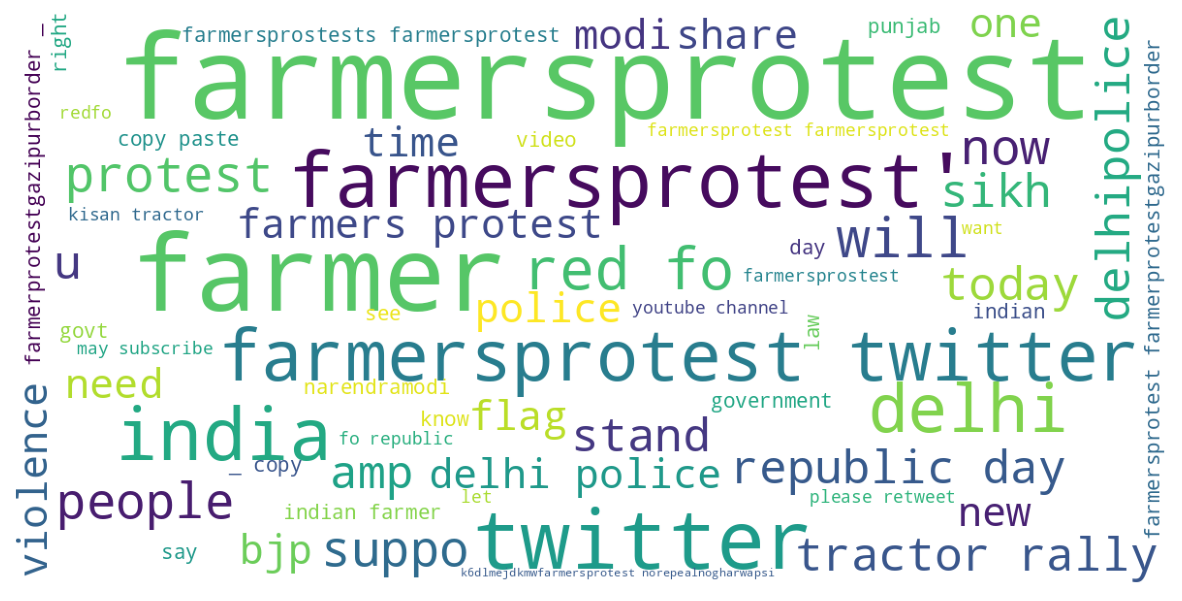

Hashtags:
1. ['republicday',
2. 'farmersprotest',
3. 'farmlaws',
4. 'newsmo',
5. 'vertical',
6. 're']
7. ['kisanektazindaabaad',
8. '26jandelhitractorparade']
9. ['farmersprotest',
10. '26jandelhichalo']


In [ ]:
start_date = "2021-01-26 00:00:00+00:00"
end_date = "2021-02-01 00:00:00+00:00"
seg_dataset3 = segment_by_date(start_date, end_date, farmers, 'datetime')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset3, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2021-01-26 00:00:00+00:00 and 2021-02-01 00:00:00+00:00:

Positive Tweets: 3868
Neutral Tweets: 15813
Negative Tweets: 19057

Total Tweets: 38738

Keywords:
1. ('farmersprotest', 11053)
2. ('farmers', 2080)
3. ('farmersprotest twitter', 1601)
4. ('protest', 1206)
5. ('farmers protest', 889)
6. ('delhi police', 798)
7. ('delhi', 738)
8. ('bjp', 674)
9. ('flag', 563)
10. ('sikhs', 549)

Positive Keywords:
1. ('farmersprotest', 1396)
2. ('farmersprotest twitter', 399)
3. ('republic day', 196)
4. ('farmers', 172)
5. ('historictractormarch farmersprotest', 97)
6. ('republic', 89)
7. ('peacefulprotestcontinues farmersprotest', 79)
8. ('farmersstandingfirm', 75)
9. ('indian republica', 67)
10. ('reclaim indian', 67)

Neutral Keywords:
1. ('farmersprotest', 5498)
2. ('farmersprotest twitter', 747)
3. ('farmers', 716)
4. ('farmers protest', 476)
5. ('protest', 395)
6. ('tractor rally', 348)
7. ('delhi', 293)
8. ('farmersprotest farmerprotestgazipurborder', 275)
9. ('farmerprotestgazipurborder', 275)
10. ('delhi police', 274)

Negative Keywords:
1. ('farmersprotest', 4159)
2. ('farmers', 1192)
3. ('protest', 765)
4. ('delhi police', 506)
5. ('bjp', 480)
6. ('farmersprotest twitter', 455)
7. ('farmers protest', 387)
8. ('delhi', 380)
9. ('flag', 352)
10. ('sikhs', 342)

```



Public Sentiment between 2020-11-26 00:00:00+00:00 and 2020-11-28 00:00:00+00:00: 

Positive Tweets: 1219
Neutral Tweets: 6430
Negative Tweets: 8173

Total Tweets: 15822

Keywords:
1. ('farmersprotest', 5076)
2. ('farmers', 2101)
3. ('farmersprotest farmersdillichalo', 717)
4. ('farmersprotest twitter', 614)
5. ('farmers farmersprotest', 591)
6. ('protest', 508)
7. ('haryana', 434)
8. ('farmers protest', 375)
9. ('delhi', 343)
10. ('bjp', 327)

Positive Keywords: 
1. ('farmersprotest', 473)
2. ('farmers', 141)
3. ('farmersprotest twitter', 106)
4. ('farmersprotest farmersdillichalo', 80)
5. ('farmersdillichalo', 46)
6. ('farmers farmersprotest', 35)
7. ('farmersdillichalo twitter', 30)
8. ('farmersdillichalo farmersprotest', 29)
9. ('constitution day', 27)
10. ('farmer', 26)

Neutral Keywords: 
1. ('farmersprotest', 2484)
2. ('farmers', 779)
3. ('farmersprotest farmersdillichalo', 347)
4. ('farmers farmersprotest', 268)
5. ('farmersprotest twitter', 254)
6. ('haryana', 201)
7. ('delhi'

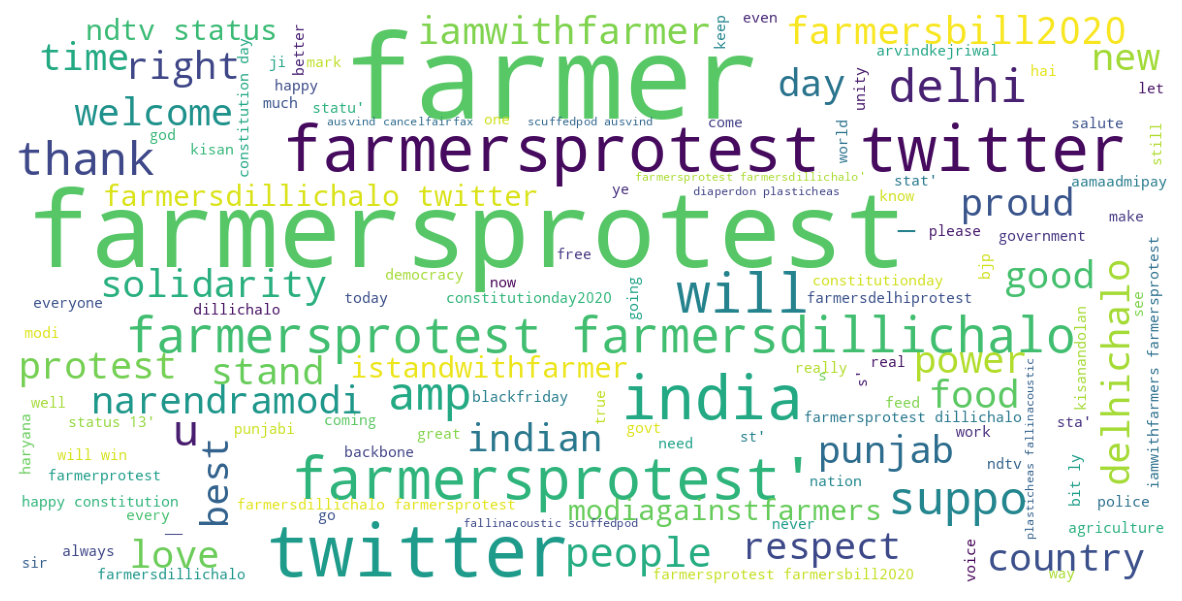

Wordcloud (Negative):


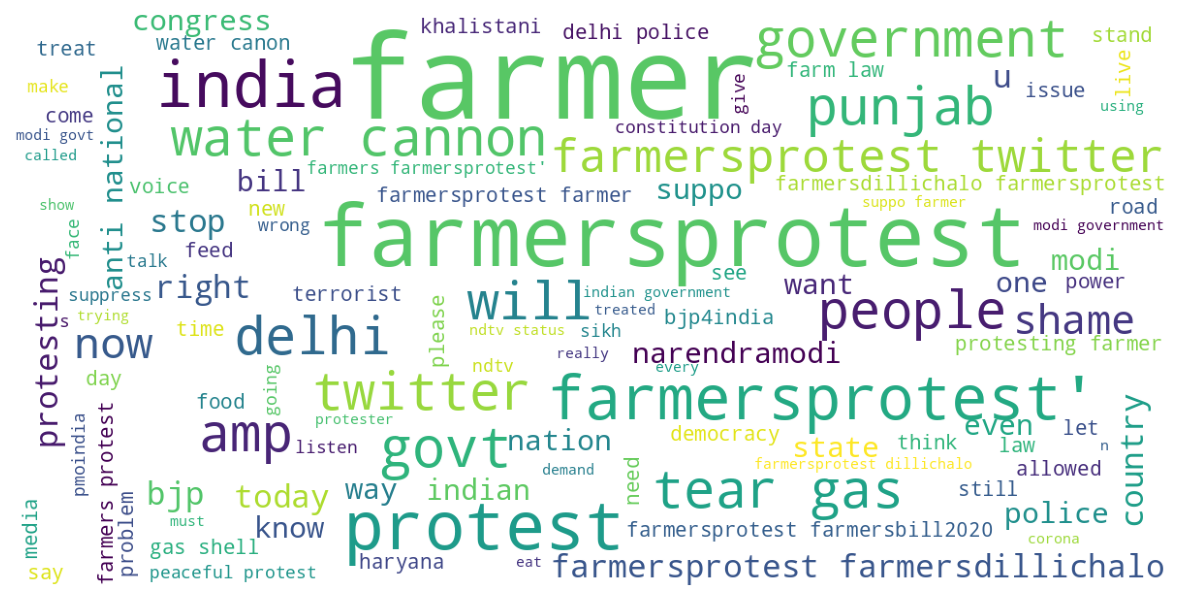

Wordcloud (Neutral):


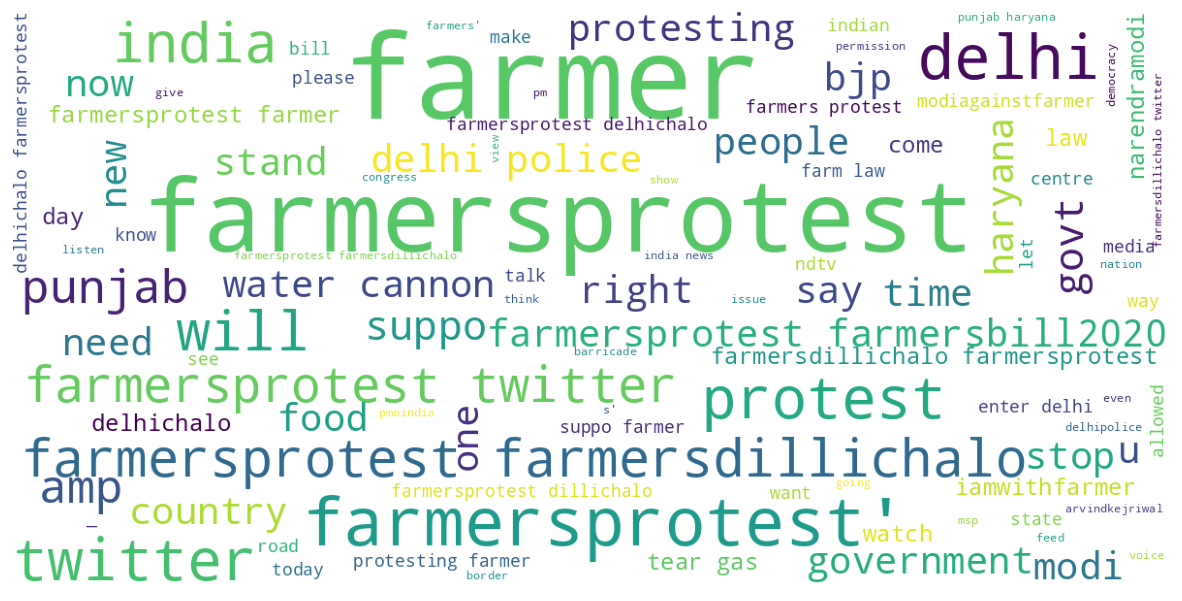

Hashtags:
1. ['farmersprotest']
2. ['modiagainstfarmers',
3. 'farmersprotest']
4. ['farmersprotest',
5. 'antifarmeracts']
6. ['delhi',
7. 'india',
8. 'farmbills2020',
9. 'modi',
10. 'indianarmy',


In [ ]:
start_date = "2020-11-26 00:00:00+00:00"
end_date = "2020-11-28 00:00:00+00:00"
seg_dataset4 = segment_by_date(start_date, end_date, farmers, 'datetime')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset4, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2020-11-26 00:00:00+00:00 and 2020-11-28 00:00:00+00:00:

Positive Tweets: 1219
Neutral Tweets: 6430
Negative Tweets: 8173

Total Tweets: 15822

Keywords:
1. ('farmersprotest', 5076)
2. ('farmers', 2101)
3. ('farmersprotest farmersdillichalo', 717)
4. ('farmersprotest twitter', 614)
5. ('farmers farmersprotest', 591)
6. ('protest', 508)
7. ('haryana', 434)
8. ('farmers protest', 375)
9. ('delhi', 343)
10. ('bjp', 327)

Positive Keywords:
1. ('farmersprotest', 473)
2. ('farmers', 141)
3. ('farmersprotest twitter', 106)
4. ('farmersprotest farmersdillichalo', 80)
5. ('farmersdillichalo', 46)
6. ('farmers farmersprotest', 35)
7. ('farmersdillichalo twitter', 30)
8. ('farmersdillichalo farmersprotest', 29)
9. ('constitution day', 27)
10. ('farmer', 26)

Neutral Keywords:
1. ('farmersprotest', 2484)
2. ('farmers', 779)
3. ('farmersprotest farmersdillichalo', 347)
4. ('farmers farmersprotest', 268)
5. ('farmersprotest twitter', 254)
6. ('haryana', 201)
7. ('delhi', 169)
8. ('protest', 159)
9. ('farmersdillichalo', 142)
10. ('farmersprotest farmersbill2020', 128)

Negative Keywords:
1. ('farmersprotest', 2119)
2. ('farmers', 1181)
3. ('protest', 340)
4. ('farmersprotest farmersdillichalo', 290)
5. ('farmers farmersprotest', 288)
6. ('farmers protest', 257)
7. ('farmersprotest twitter', 254)
8. ('protesting', 246)
9. ('bjp', 239)
10. ('haryana', 220)
```



Public Sentiment between 2020-11-25 00:00:00+00:00 and 2020-11-26 00:00:00+00:00: 



Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Positive Tweets: 26
Neutral Tweets: 154
Negative Tweets: 166

Total Tweets: 346

Keywords:
1. ('farmersprotest', 112)
2. ('farmers', 46)
3. ('farmersprotest twitter', 26)
4. ('haryana', 24)
5. ('water cannon', 15)
6. ('protesting farmers', 12)
7. ('farmers farmersprotest', 10)
8. ('punjab farmers', 9)
9. ('water cannons', 9)
10. ('farmersprotest farmersdillichalo', 9)

Positive Keywords: 
1. ('farmersprotest', 9)
2. ('farmers', 5)
3. ('farmersprotest farmers', 2)
4. ('india farmers', 2)
5. ('farmers streets', 2)
6. ('punjabis', 2)
7. ('bullet farmersprotest', 2)
8. ('farmersprotest thank', 2)
9. ('water bullet', 2)
10. ('narendramodi ji', 2)

Neutral Keywords: 
1. ('farmersprotest', 63)
2. ('farmers', 20)
3. ('haryana', 14)
4. ('farmersprotest twitter', 11)
5. ('farmers farmersprotest', 8)
6. ('water cannon', 7)
7. ('suppo farmers', 5)
8. ('punjab haryana', 4)
9. ('punjab farmers', 4)
10. ('water cannons', 4)

Negative Keywords: 
1. ('farmersprotest', 40)
2. ('farmers', 21)
3. ('farmer

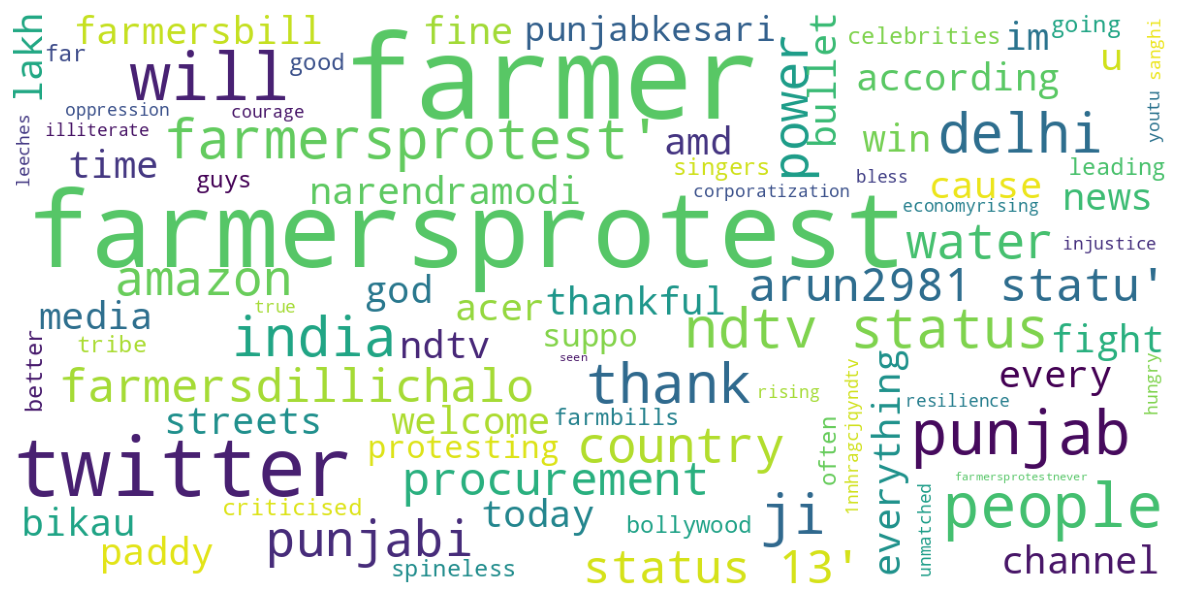

Wordcloud (Negative):


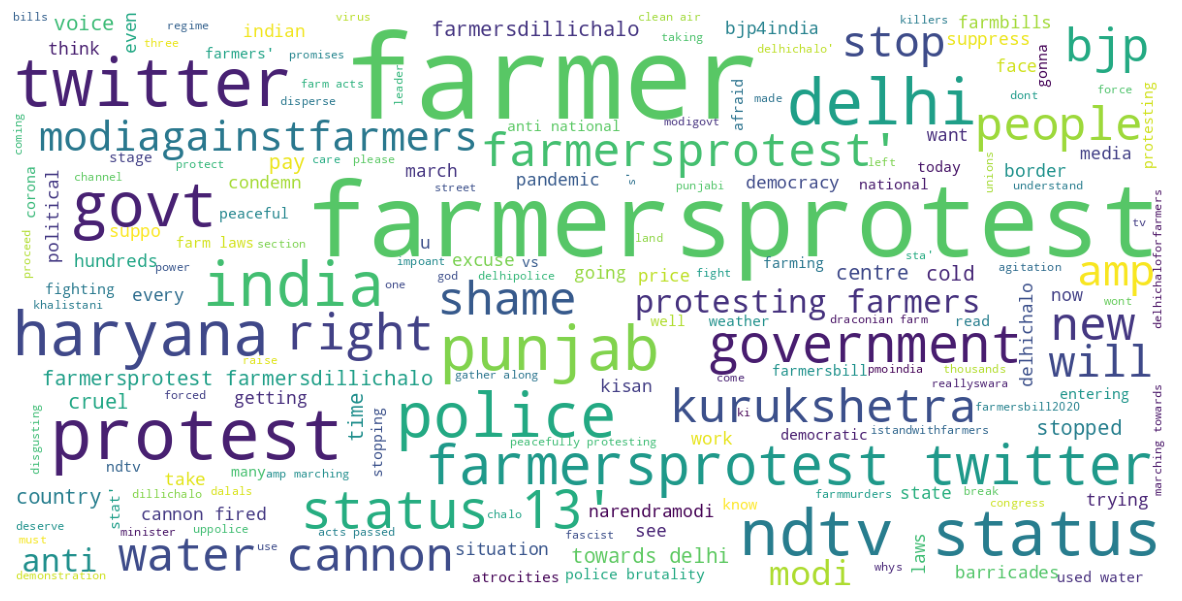

Wordcloud (Neutral):


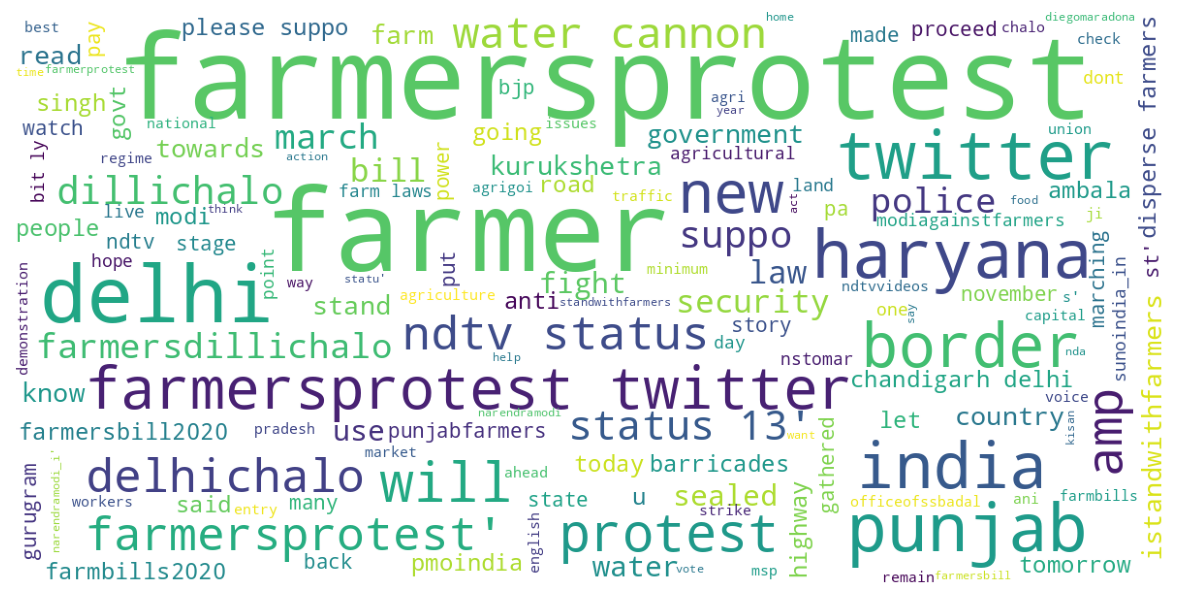

Hashtags:
1. article19
2. india
3. farmersprotest
4. recognizeesportsinindia
5. farmersbill2020
6. farmlaws
7. farmers
8. modigovt
9. modihaitomumkinhai
10. agriculture


In [ ]:
start_date = "2020-11-25 00:00:00+00:00"
end_date = "2020-11-26 00:00:00+00:00"
seg_dataset5 = segment_by_date(start_date, end_date, farmers, 'datetime')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset5, start_date, end_date, 'renderedContent')

```
Public Sentiment between 2020-11-25 00:00:00+00:00 and 2020-11-26 00:00:00+00:00:

Positive Tweets: 26
Neutral Tweets: 154
Negative Tweets: 166

Total Tweets: 346

Keywords:
1. ('farmersprotest', 112)
2. ('farmers', 46)
3. ('farmersprotest twitter', 26)
4. ('haryana', 24)
5. ('water cannon', 15)
6. ('protesting farmers', 12)
7. ('farmers farmersprotest', 10)
8. ('punjab farmers', 9)
9. ('water cannons', 9)
10. ('farmersprotest farmersdillichalo', 9)

Positive Keywords:
1. ('farmersprotest', 9)
2. ('farmers', 5)
3. ('farmersprotest farmers', 2)
4. ('india farmers', 2)
5. ('farmers streets', 2)
6. ('punjabis', 2)
7. ('bullet farmersprotest', 2)
8. ('farmersprotest thank', 2)
9. ('water bullet', 2)
10. ('narendramodi ji', 2)

Neutral Keywords:
1. ('farmersprotest', 63)
2. ('farmers', 20)
3. ('haryana', 14)
4. ('farmersprotest twitter', 11)
5. ('farmers farmersprotest', 8)
6. ('water cannon', 7)
7. ('suppo farmers', 5)
8. ('punjab haryana', 4)
9. ('punjab farmers', 4)
10. ('water cannons', 4)

Negative Keywords:
1. ('farmersprotest', 40)
2. ('farmers', 21)
3. ('farmersprotest twitter', 14)
4. ('protesting farmers', 10)
5. ('haryana', 10)
6. ('water cannon', 8)
7. ('farmers kurukshetra', 6)
8. ('farmersprotest farmersdillichalo', 6)
9. ('protesting', 5)
10. ('punjab farmers', 5)

Hashtags:
1. article19
2. india
3. farmersprotest
4. recognizeesportsinindia
5. farmersbill2020
6. farmlaws
7. farmers
8. modigovt
9. modihaitomumkinhai
10. agriculture
```

And we have now finished conducting our analysis!